## import

In [226]:
import time
import os
import pandas as pd
import numpy as np
import healpy as hp
import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from healpy.fitsfunc import read_map
import matplotlib.style as style

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
style.use('tableau-colorblind10')
colors = sns.color_palette("colorblind").as_hex()
#style.use('seaborn-colorblind')

# Tableau Color Blind 10
tableau_colors = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau_colors)):  
    r, g, b = tableau_colors[i]  
    tableau_colors[i] = (r / 255., g / 255., b / 255.)

############### CMB colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap

## extract CMB maps and masks

In [2]:
# Define some fixed params
NSIDE = 2048                                                                      # given in the name of the maps
APO = 5                                                                           # apodization length
HDU = 1
FREQ = 143 

gal_cover = 60                                                                    # % of cover in galacitc plane

GALCOVER_DICT = {
    'GAL020': 0,
    'GAL040': 1,
    'GAL060': 2,
    'GAL070': 3,
    'GAL080': 4,
    'GAL090': 5,
    'GAL097': 6,
    'GAL099': 7
}

FREQ_PS_DICT = {
    'F100': 0,
    'F143': 1,
    'F217': 2,
    'F353': 3,
    'F545': 4,
    'F857': 5,
} 

def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    
    with fits.open(filepath) as hdul:
        hdul = fits.open(filepath)
        data = hdul[hdu].data.astype(np.float)                               # hdul is a list of HDU objects
    
    return data

# define filepaths
filepath_hm1 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits'         # map for half mission 1 143 GHZ
filepath_hm2 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits'         # map for half mission 2 143 GHZ
filepath_gp = f'data/HFI_Mask_GalPlane-apo{APO}_2048_R2.00.fits'           # galactic plane mask for input apodization length
filepath_ps = 'data/HFI_Mask_PointSrc_2048_R2.00.fits'                     # mask point source
filepath_beamwin1 = 'Bl_T_R3.01_fullsky_143hm1x143hm1.fits',               # beam transfer function for hm1
filepath_beamwin2 = 'Bl_T_R3.01_fullsky_143hm1x143hm2.fits',               # beam transfer function for hm2
         

start1 = time.time()
print(f'Started Planck data extraction:')
print('='*80)
# extract data by using read_map funcitn from healpy
sky_hm1, sky_hm2 = read_map(filepath_hm1, field=0, hdu=HDU), read_map(filepath_hm2, field=0, hdu=HDU)

field_gp = GALCOVER_DICT[f'GAL0{gal_cover}']
mask_gp = read_map(filepath_gp, field=field_gp, hdu=HDU)

field_ps = FREQ_PS_DICT['F143']
mask_ps = read_map(filepath_ps, field=field_ps, hdu=HDU)

# use the extract_data function to find the beam window function
beam_hm1, beam_hm2 = extract_data(filepath_beamwin1), extract_data(filepath_beamwin2)

end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

Started Planck data extraction:
It took 193.36s. to extract the Planck data files.


In [27]:
beam_hm1, beam_hm2 = beam_hm1.astype(np.float), beam_hm2.astype(np.float)

print(beam_hm1.astype(np.float), beam_hm2.astype(np.float))

[1.0000000e+00 9.9999911e-01 9.9999726e-01 ... 2.2533273e-04 2.2378347e-04
 2.2225002e-04] [1.0000000e+00 9.9999911e-01 9.9999726e-01 ... 2.2002983e-04 2.1844018e-04
 2.1686613e-04]


In [19]:
def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    with fits.open(filepath) as hdul:
        hdul = fits.open(filepath)
        data = hdul[hdu].data                                              # hdul is a list of HDU objects
    
    return data

filepath_beamwin1 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm1.fits'               # beam transfer function for hm1
filepath_beamwin2 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm2.fits'               # beam transfer function for hm2

# use the extract_data function to find the beam window function
beam_hm1, beam_hm2 = extract_data(filepath_beamwin1), extract_data(filepath_beamwin2)

## data quality check

In [8]:
BAD_DATA = -1.6375e+30

def clean_skydata(sky_array, 
                  bad_data_threshold=-1e12):
    '''
    Document once fully tested
    '''
        
    print(f'Carryiing out data quality of sky map:')
    print('-'*80)
    
    init_mean = np.mean(sky_array)
    if np.abs(init_mean) > 1:
        print('Skymap contains bad data')
        
        sky_array[sky_array <  bad_data_threshold] = 0
    
        print(f'The mean of the sky map corresponds to: {np.mean(sky_array):.2e}')
    
    else:
        print(f'Data is already clean.')
    
    print(f'Currently, the mean is {np.mean(sky_array):.2e}')

    
    
    mean_sky = np.mean(sky_array)
    print(f'Data Quality check completed.') 
    print('='*80)
    
    return(sky_array)

sky_hm1, sky_hm2 = clean_skydata(sky_hm1), clean_skydata(sky_hm2)

Carryiing out data quality of sky map:
--------------------------------------------------------------------------------
Data is already clean.
Currently, the mean is 1.57e-04
Data Quality check completed.
Carryiing out data quality of sky map:
--------------------------------------------------------------------------------
Skymap contains bad data
The mean of the sky map corresponds to: 1.57e-04
Currently, the mean is 1.57e-04
Data Quality check completed.


In [ ]:
#npy_filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.npy',        # map for half mission 1 143 GHZ
#             'HFI_SkyMap_143_2048_R3.01_halfmission-2.npy',        # map for half mission 2 143 GHZ
#             'HFI_Mask_GalPlane-apo5_2048_R2.00_GAL060_.npy',              # galactic plane mask for input apodization
#             'HFI_Mask_PointSrc_2048_R2.00.npy',                   # mask point source
#             'Bl_T_R3.01_fullsky_143hm1x143hm1.npy',               # beam transfer function for hm1
#             'Bl_T_R3.01_fullsky_143hm1x143hm2.npy',               # beam transfer function for hm2
#            ]
#
#array_list = []
#for npy_filename in npy_filenames:
#    a = np.load('data/'+npy_filename)
#    a[a ==  -1.6375e+30] = 0
#    
#    array_list.append(a)

## plot maps

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


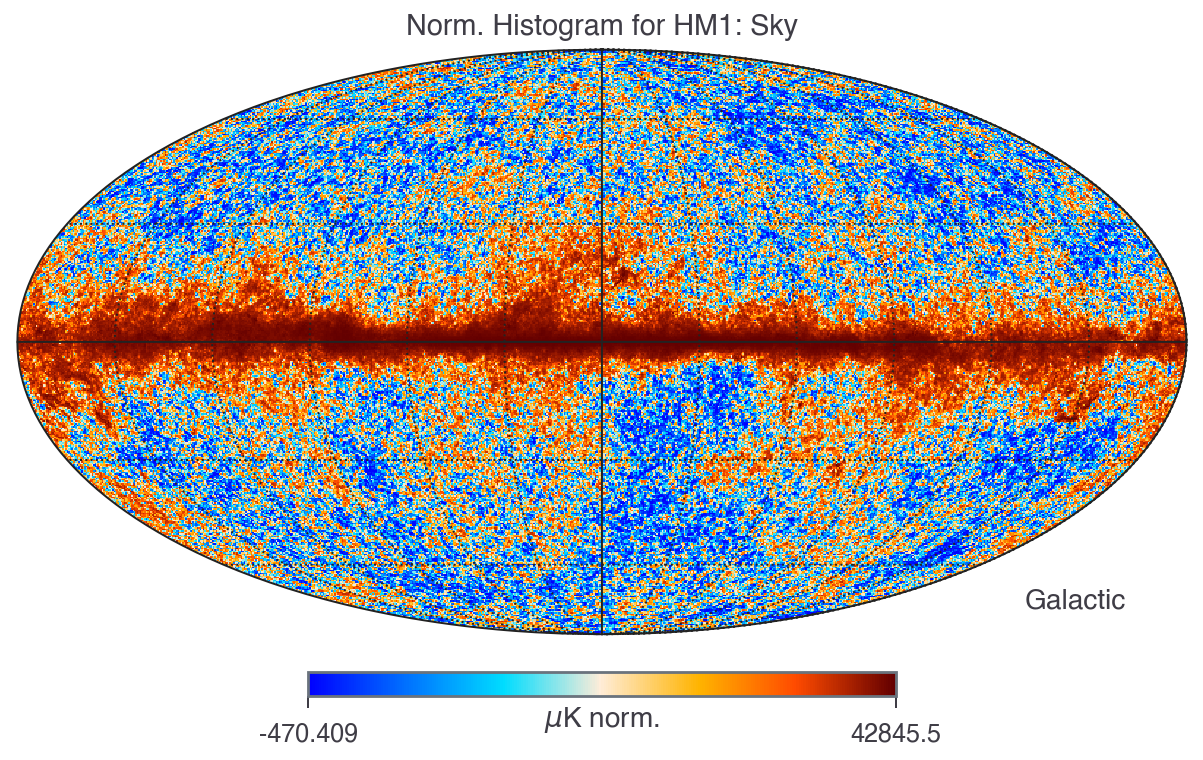

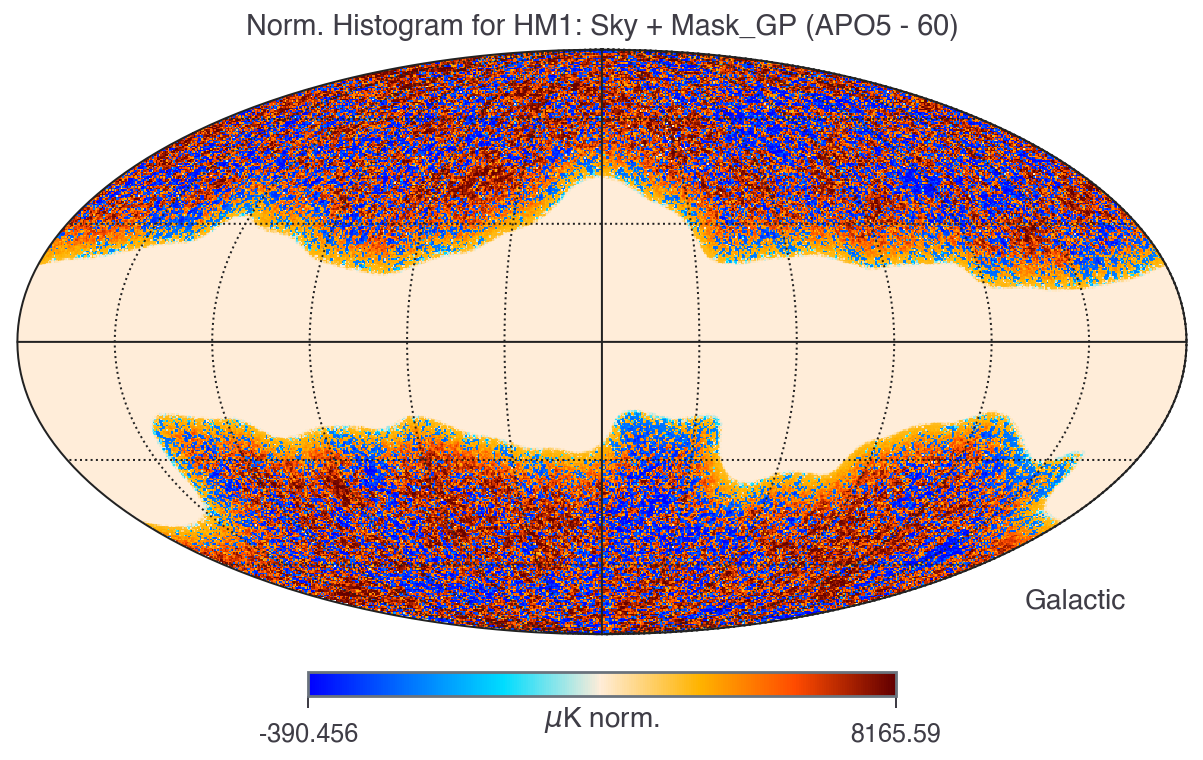

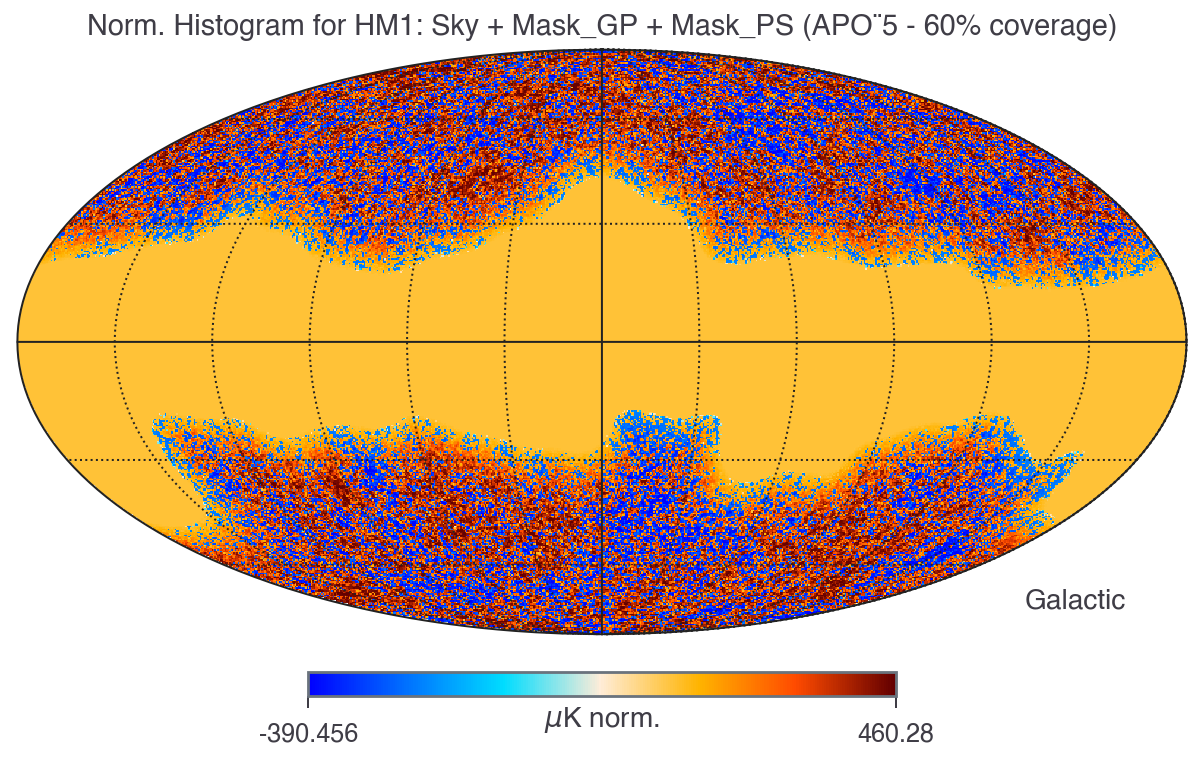

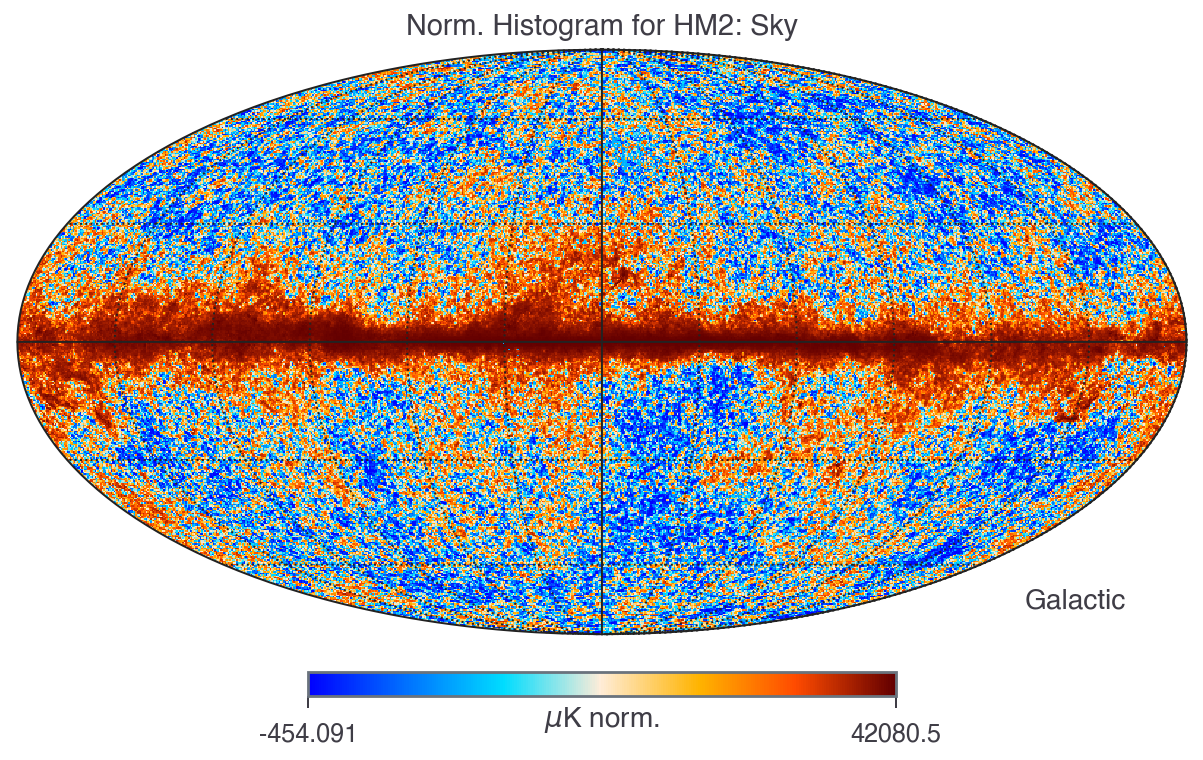

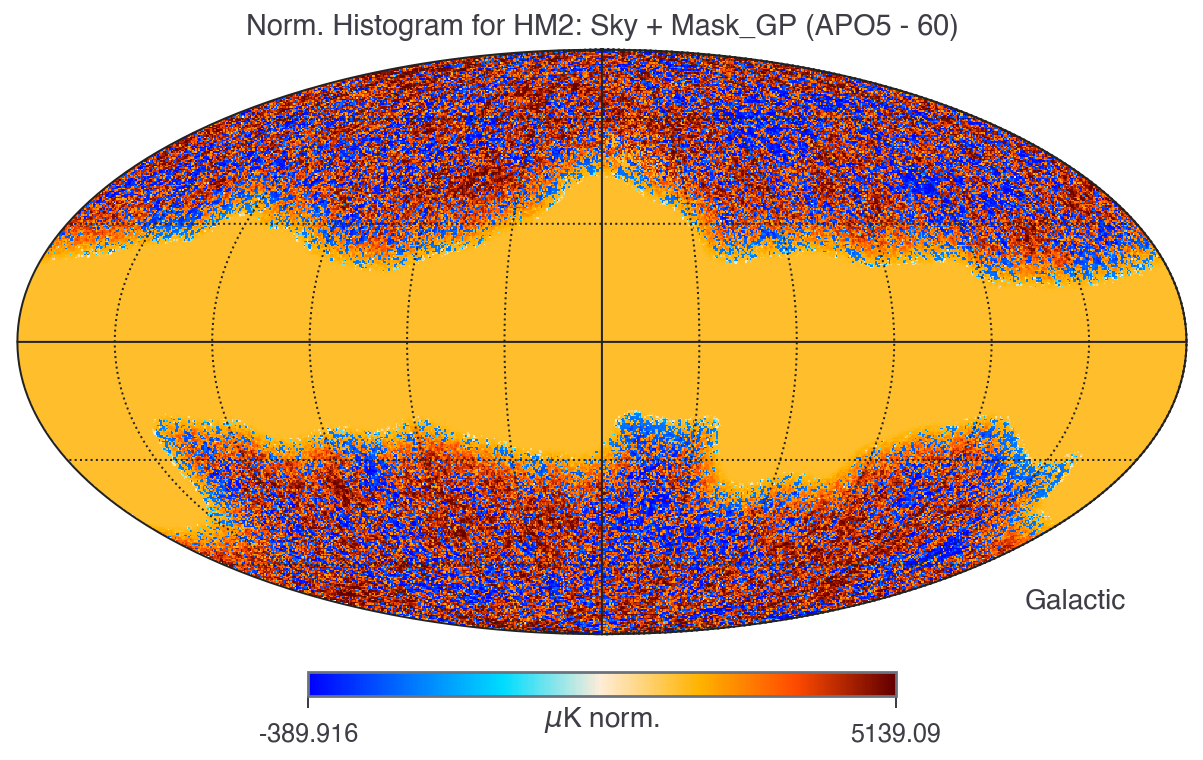

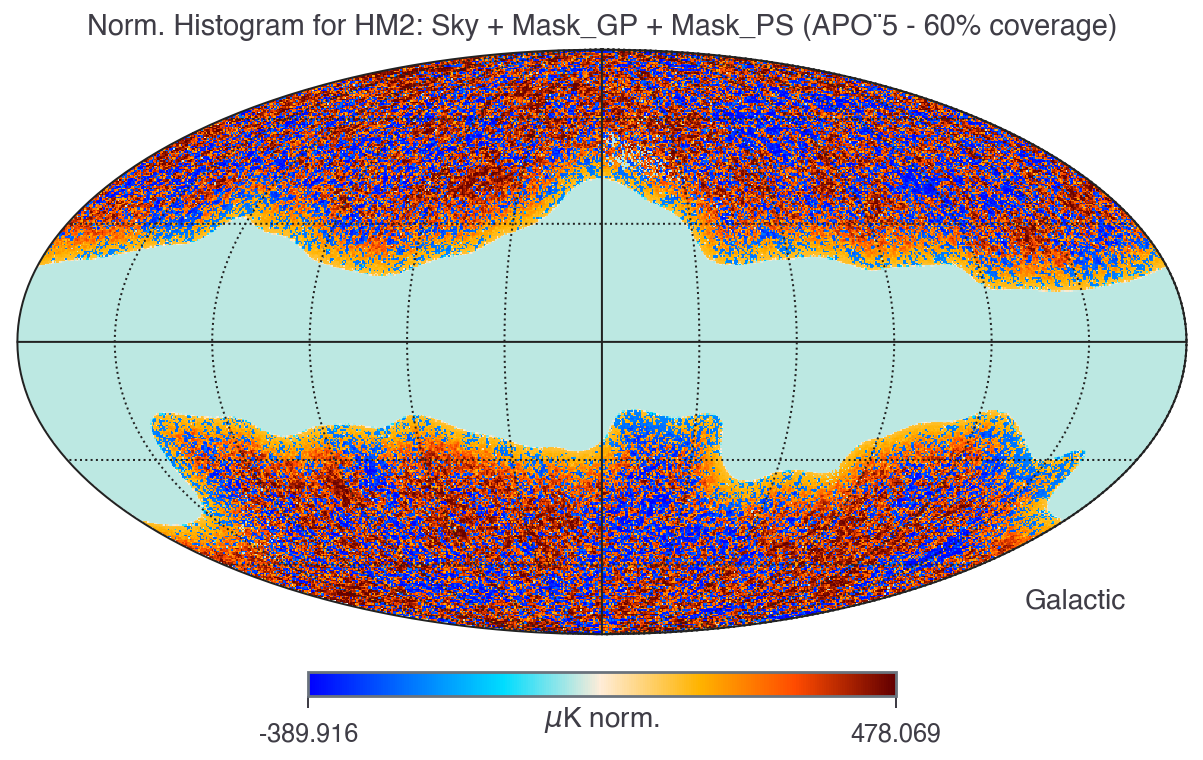

In [9]:
plot_array = [sky_hm1, sky_hm1*mask_gp, sky_hm1*mask_gp*mask_ps, 
              sky_hm2, sky_hm2*mask_gp, sky_hm2*mask_gp*mask_ps]

titles = ['Sky', f'Sky + Mask_GP (APO{APO} - {gal_cover})', f'Sky + Mask_GP + Mask_PS (APO¨{APO} - {gal_cover}% coverage)']

for i, arr in enumerate(plot_array):
    hp.mollview(arr*10**6, coord=["G"],  norm="hist",
                title=f"Norm. Histogram for HM{1 if i < 3 else 2}: {titles[i%3]}", 
                unit="$\mu$K norm.", cmap=cmap)
    
    hp.graticule()

## compute spherical harmoncis

In [10]:
def find_spherical_harmonics(sky_i, gp_mask, ps_mask, 
                             apply_mask=True):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    # rescale the sky map to mKelvin
    sky_i *= 10**6
    
    if apply_mask:
        x_masked = sky_i*gp_mask*ps_mask
    else:
        x_masked = sky_i
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, pol=False, lmax=NSIDE)             
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

It took 99.51 s. to compute a_lm
It took 137.20 s. to compute a_lm


## compute actual cross power spectrum

In [172]:
def find_power_spectrum(alm_1, alm_2, bl_1=None, bl_2=None,
                        M_ll=1, f_l=1, n_l=0, NSIDE=2048,
                        which_return='both'):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    
    start = time.time()
    # compute pseudo power spectrum
    D_l = hp.sphtfunc.alm2cl(alm_1, alm_2)
    
    if which_return=='pseudo':
        end = time.time()
        print(f'It took {end-start:.2f} s. to compute D_l')
        
        return D_l
    elif which_return=='actual' or which_return=='both':
        # now define all the instrument related biases
        bl_1, bl_2 = bl_1.astype(np.float), bl_2.astype(np.float)
        p_l = hp.sphtfunc.pixwin(NSIDE, lmax=len(bl_1)-1)
        # calculate actual power spectrum
        C_l = D_l/(p_l**2 * bl_1*bl_2)
        
        end = time.time()
        print(f'It took {end-start:.2f} s. to compute C_l')
        
        if which_return=='both':
            return (D_l, C_l)
        
        else:
            return C_l
        

D_l, C_l = find_power_spectrum(a_lm_1, a_lm_2, beam_hm1, beam_hm2, which_return='both')

def clean_power_spectrum(C_l, ind_low=20, ind_max=2000,
                         decimate=True, n_dec=2):
    '''
    document function once fully tested
    '''
    # define multipole array
    C_l = C_l[ind_low:ind_max]
    
    l = np.arange(len(C_l))
    C_lbinned = l*(l+1)*C_l/(2*np.pi)

    # decimate each array
    if decimate:
        n_dec = 2
        C_lbinned, l = C_lbinned[::n_dec], l[::n_dec]
    
    return (l, C_lbinned)

l, C_lbinned = clean_power_spectrum(C_l)

It took 0.66 s. to compute C_l


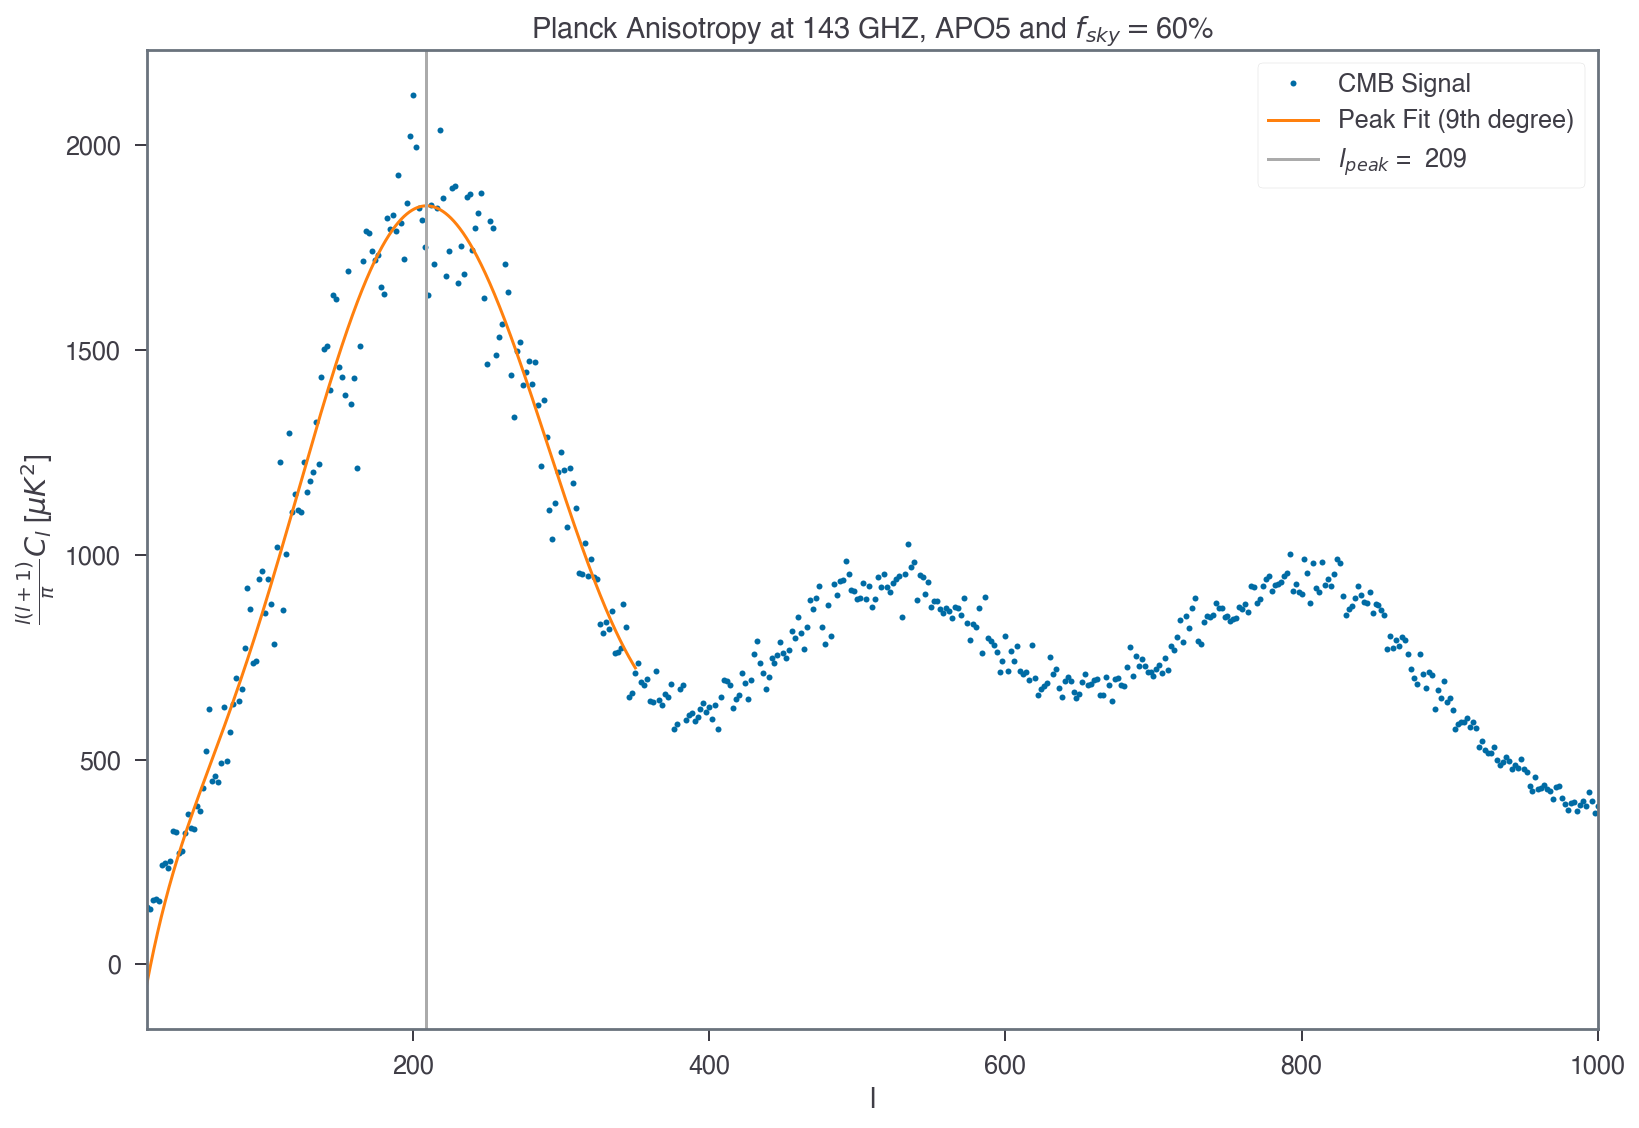

In [227]:
# find a fit using a polynomial approx
def poly_n(x,w):
    '''
    Document once function has been fully tested
    '''
    X = np.array([x**i for i in range(len(w))])
    y = np.matmul(w,X)
    
    return y


# find an approximate fit for the first peak
ind_fit_a, ind_fit_b = 20, 350  
N = 10

w = np.polyfit(l[ind_fit_a:ind_fit_b], C_lbinned[ind_fit_a:ind_fit_b], deg=N)[::-1]       # the last bit reverts array so lowest coefficient first

l_s = np.linspace(ind_fit_a, ind_fit_b, num=5000)
cl_s = poly_n(l_s,w)

# find the maximum of the power spectrum and its associated multipole
ind_peak = np.where(cl_s == np.max(cl_s))
l_peak = l_s[ind_peak][0]

fig, ax = plt.subplots(figsize=(13,9))
ax.plot(l, C_lbinned, 'o', markersize=3, label='CMB Signal', color=tableau_colors[0])
ax.plot(l_s, cl_s, '-', label=f'Peak Fit ({N-1}th degree)', color=tableau_colors[1])
ax.axvline(l_peak, label='$l_{peak}$ = '+f' {l_peak:.0f}', color=tableau_colors[2])

#ax.set_yscale('log')
ax.set_xlim([20,1000])
#ax.set_ylim([10,10**4])

ax.set_title(f'Planck Anisotropy at {FREQ} GHZ, APO{APO} and ' + '$f_{sky} = $'+f'{gal_cover}%')
ax.set_xlabel('l')
ax.set_ylabel(r'$\frac{l(l+1)}{\pi} C_l$ [$\mu K^2$]')

plt.legend(loc=0)

save_fig = True
if save_fig:
    try:
        plt.savefig(f'plots/CMB_CrossPowerSpectrum__{FREQ}x{FREQ}__APO{APO}__{gal_cover}%.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(f'plots/CMB_CrossPowerSpectrum__{FREQ}x{FREQ}__APO{APO}__{gal_cover}%.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()